In [1]:
#https://github.com/wjbmattingly/spacy_tutorials_3x/blob/main/02_02_formal_test.ipynb
import spacy
import json
import re
import random
from pathlib import Path
import os
os.chdir('..')
print(os.getcwd())
CONTRACTS_FOLDER = 'Datasets/400docs/'
CONTRACTS_JSON = CONTRACTS_FOLDER+'contract.json'
%matplotlib inline

d:\Documentos\Mis docs\Research\hcommonk-anonymizer\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Documentos\Mis docs\Research\hcommonk-anonymizer


In [2]:
class Contract:
    def __init__(self, contract_json):
        self.document_name = contract_json['document_name']
        self.document_uuid = contract_json['document_uuid']
        #self.document_content = contract_json['document_content']
        self.document_content = self.load_document_content(contract_json['document_content'])
        self.extractions = contract_json['extractions']
        self.extractions_tree = contract_json['extractions_tree']
        self.document_split = contract_json['document_split']
        #self.annotations = contract_json['annotations']
        self.annotations = [Contract_annotation(self.document_name, annotation) for annotation in contract_json['annotations']]
        self.annotations.sort(key=lambda x: x.char_start)
        self.annotated_text = self.replace_text_with_annotations()
    
    def load_document_content(self, previous_content):
        if previous_content == 'None' or previous_content == None:
            document_path = CONTRACTS_FOLDER + self.document_uuid + '/text'
            with open(document_path, 'r', encoding="utf8") as file:
                document_content = file.read()
            return document_content
        else:
            return previous_content
    
    def replace_text_with_annotations(self):
        annotated_text = ''
        last_pos = 0
        for annotation in self.annotations:
            annotated_text += self.document_content[last_pos:annotation.char_start]
            annotated_text += f'<{annotation.label}>'
            last_pos = annotation.char_end
        annotated_text += self.document_content[last_pos:]
        return annotated_text

    
# Class declaration of a single annotatio of a certain contract

class Contract_annotation:
    def __init__(self, document_name, annotation_json):
        self.document_name = document_name
        self.start = annotation_json['start']
        self.end = annotation_json['end']
        self.char_start = annotation_json['char_start']
        self.char_end = annotation_json['char_end']
        self.label = annotation_json['label']
        if 'uuid' in annotation_json.keys():
            self.uuid = annotation_json['uuid']
        self.text = annotation_json['text']
        self.origin = annotation_json['origin']

    def __eq__(self, other):
        return (isinstance(other, self.__class__) and
            getattr(other, 'text', None) == self.text)

    def __hash__(self):
        return hash(self.text + str(self.char_start) + str(self.char_end))

In [3]:
CONTRACTS_FOLDER = 'Datasets/400docs/'
CONTRACTS_JSON = CONTRACTS_FOLDER+'contract.json'
# 1. Load contrats json file
with open(CONTRACTS_JSON) as json_file:
    contracts_json = json.load(json_file)

# 2. Load all the contracts from CONTRACTS_FOLDER 
contracts = []
for document in contracts_json['documents']:
    contracts.append(Contract(document))
#   2.1 clean data
#[contract.clean_document_content() for contract in contracts]

#   2.2 remove collisions
print(f'Total number of annotations before removing collisions: {sum([len(contract.annotations) for contract in contracts])}')
for contract in contracts:
    final_annotations = [contract.annotations[0]]
    for i in range(1,len(contract.annotations)):
        previous_annotation = contract.annotations[i-1]
        current_annotation = contract.annotations[i]
        if current_annotation.char_start >= previous_annotation.char_end:
            # no collision
            final_annotations.append(current_annotation)
        else:
            # there is a collision, what should we do?
            # currently we are removing it
            pass
    contract.annotations = final_annotations
print(f'Total number of annotations after removing collisions: {sum([len(contract.annotations) for contract in contracts])}')
contracts = [contract for contract in contracts if contract.document_split == 'TEST']

Total number of annotations before removing collisions: 8951
Total number of annotations after removing collisions: 8815


In [4]:
def prepare_train_data_spacy(contracts):
    """
    TRAIN_DATA = [
        ('Who is Nishanth?', {'entities': [(7, 15, 'PERSON')]}),
        ('I like London and Berlin.', {'entities': [(7, 13, 'LOC'), (18, 24, 'LOC')]})
    ]
    """
    train_data = []
    for contract in contracts:
        entities = [(annotation.char_start, annotation.char_end, annotation.label) for annotation in contract.annotations]
        train_data.append((contract.document_content, {'entities' : entities}))
    return train_data

In [5]:
docs = prepare_train_data_spacy(contracts)

In [6]:
from spacy.training import offsets_to_biluo_tags
def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        #print (doc)
        new = nlp.make_doc(doc[0])
        entities = doc[1]["entities"]
        bilou_entities = offsets_to_biluo_tags(new, entities)
        final = []
        for item in bilou_entities:
            final.append(get_cleaned_label(item))
        target_vector.extend(final)
    return target_vector

In [7]:
def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = nlp(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

In [8]:
def get_model_labels():
    labels = list(nlp.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)
def get_dataset_labels():
    return sorted(set(create_total_target_vector(docs)))

In [9]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)
    y_pred = create_total_prediction_vector(docs)
    #print (y_true)
    #print (y_pred)
    return confusion_matrix(y_true, y_pred, labels=classes)

In [10]:
# generate_confusion_matrix(docs)


In [11]:
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(docs, classes, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = 'Confusion Matrix, for SpaCy NER'
    pyplot.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
    pyplot.rcParams['figure.figsize'] = [20, 10]

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot

(array([[   132,      0,      8,      0,     12,      0,      0,      0,
            121,     64,      0],
        [     0,    108,      0,      0,      0,      0,      0,      0,
              7,     73,      0],
        [     0,      0,    552,      0,      0,      0,      0,      0,
             18,    767,      0],
        [     0,      0,      0,      0,    127,      0,      3,      0,
              8,    438,      0],
        [     0,      0,      0,      6,    567,      0,      0,      0,
              0,    264,      0],
        [     0,      0,      6,      6,      0,     96,      0,      0,
              0,    107,      0],
        [     0,      2,     17,      0,      0,      0,    540,      0,
              0,    276,      0],
        [     0,      0,      0,      0,      0,      0,      0,     57,
              0,     92,      0],
        [    20,      0,      6,      0,      0,      0,      5,      0,
           1142,    355,      0],
        [     5,     74,    745,     

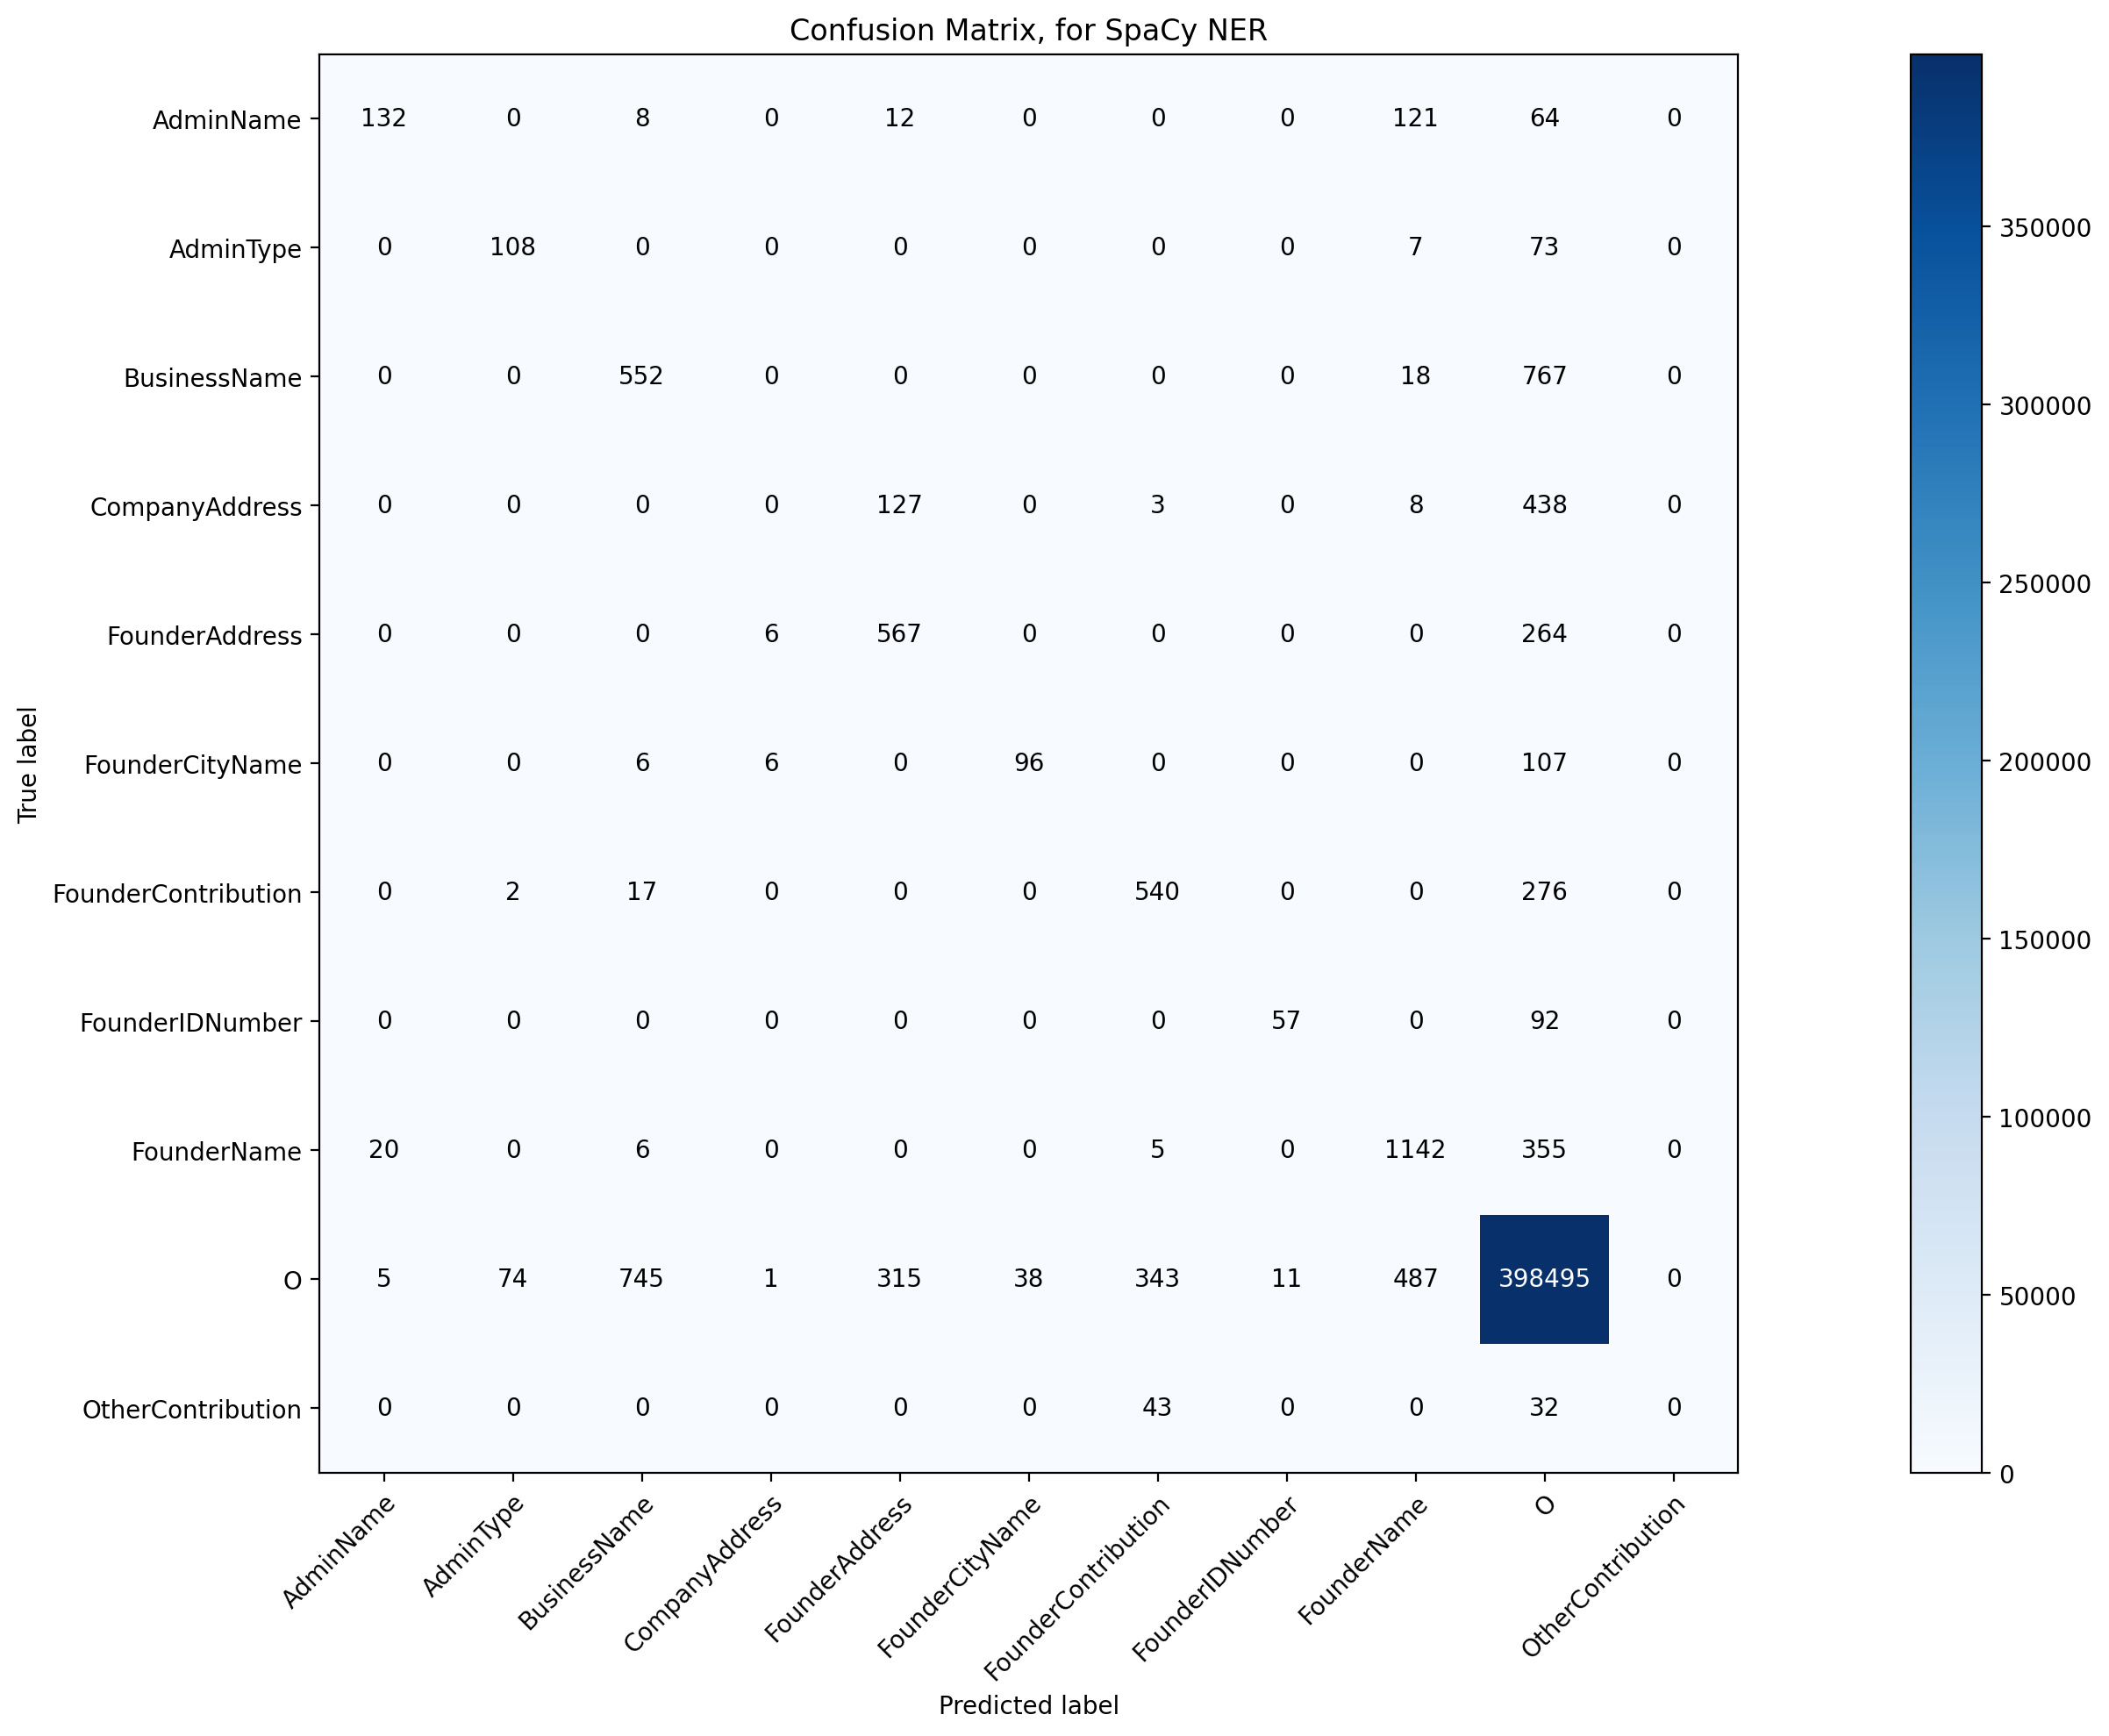

In [12]:
nlp = spacy.load('models/spacy_models_cl/400docs/model-best')
plot_confusion_matrix(docs,classes=get_dataset_labels(),normalize=False)

(array([[   299,      0,      0,      0,      0,      0,      0,      0,
             21,     17,      0],
        [     0,    176,      0,      0,      0,      0,      0,      0,
              4,      8,      0],
        [     0,      0,   1272,      0,      0,      8,      0,      0,
              0,     57,      0],
        [     0,      0,      0,    542,     14,      0,      0,      0,
              4,     16,      0],
        [     0,      0,      0,      0,    785,      0,      8,      0,
              0,     44,      0],
        [     0,      0,      6,      0,      0,    209,      0,      0,
              0,      0,      0],
        [     0,      0,      0,      0,      0,      0,    464,      0,
              0,    371,      0],
        [     0,      0,      0,      0,      0,      0,      0,    147,
              0,      2,      0],
        [     5,      0,      0,      0,      0,      0,      0,      0,
           1482,     41,      0],
        [    10,      3,     76,     

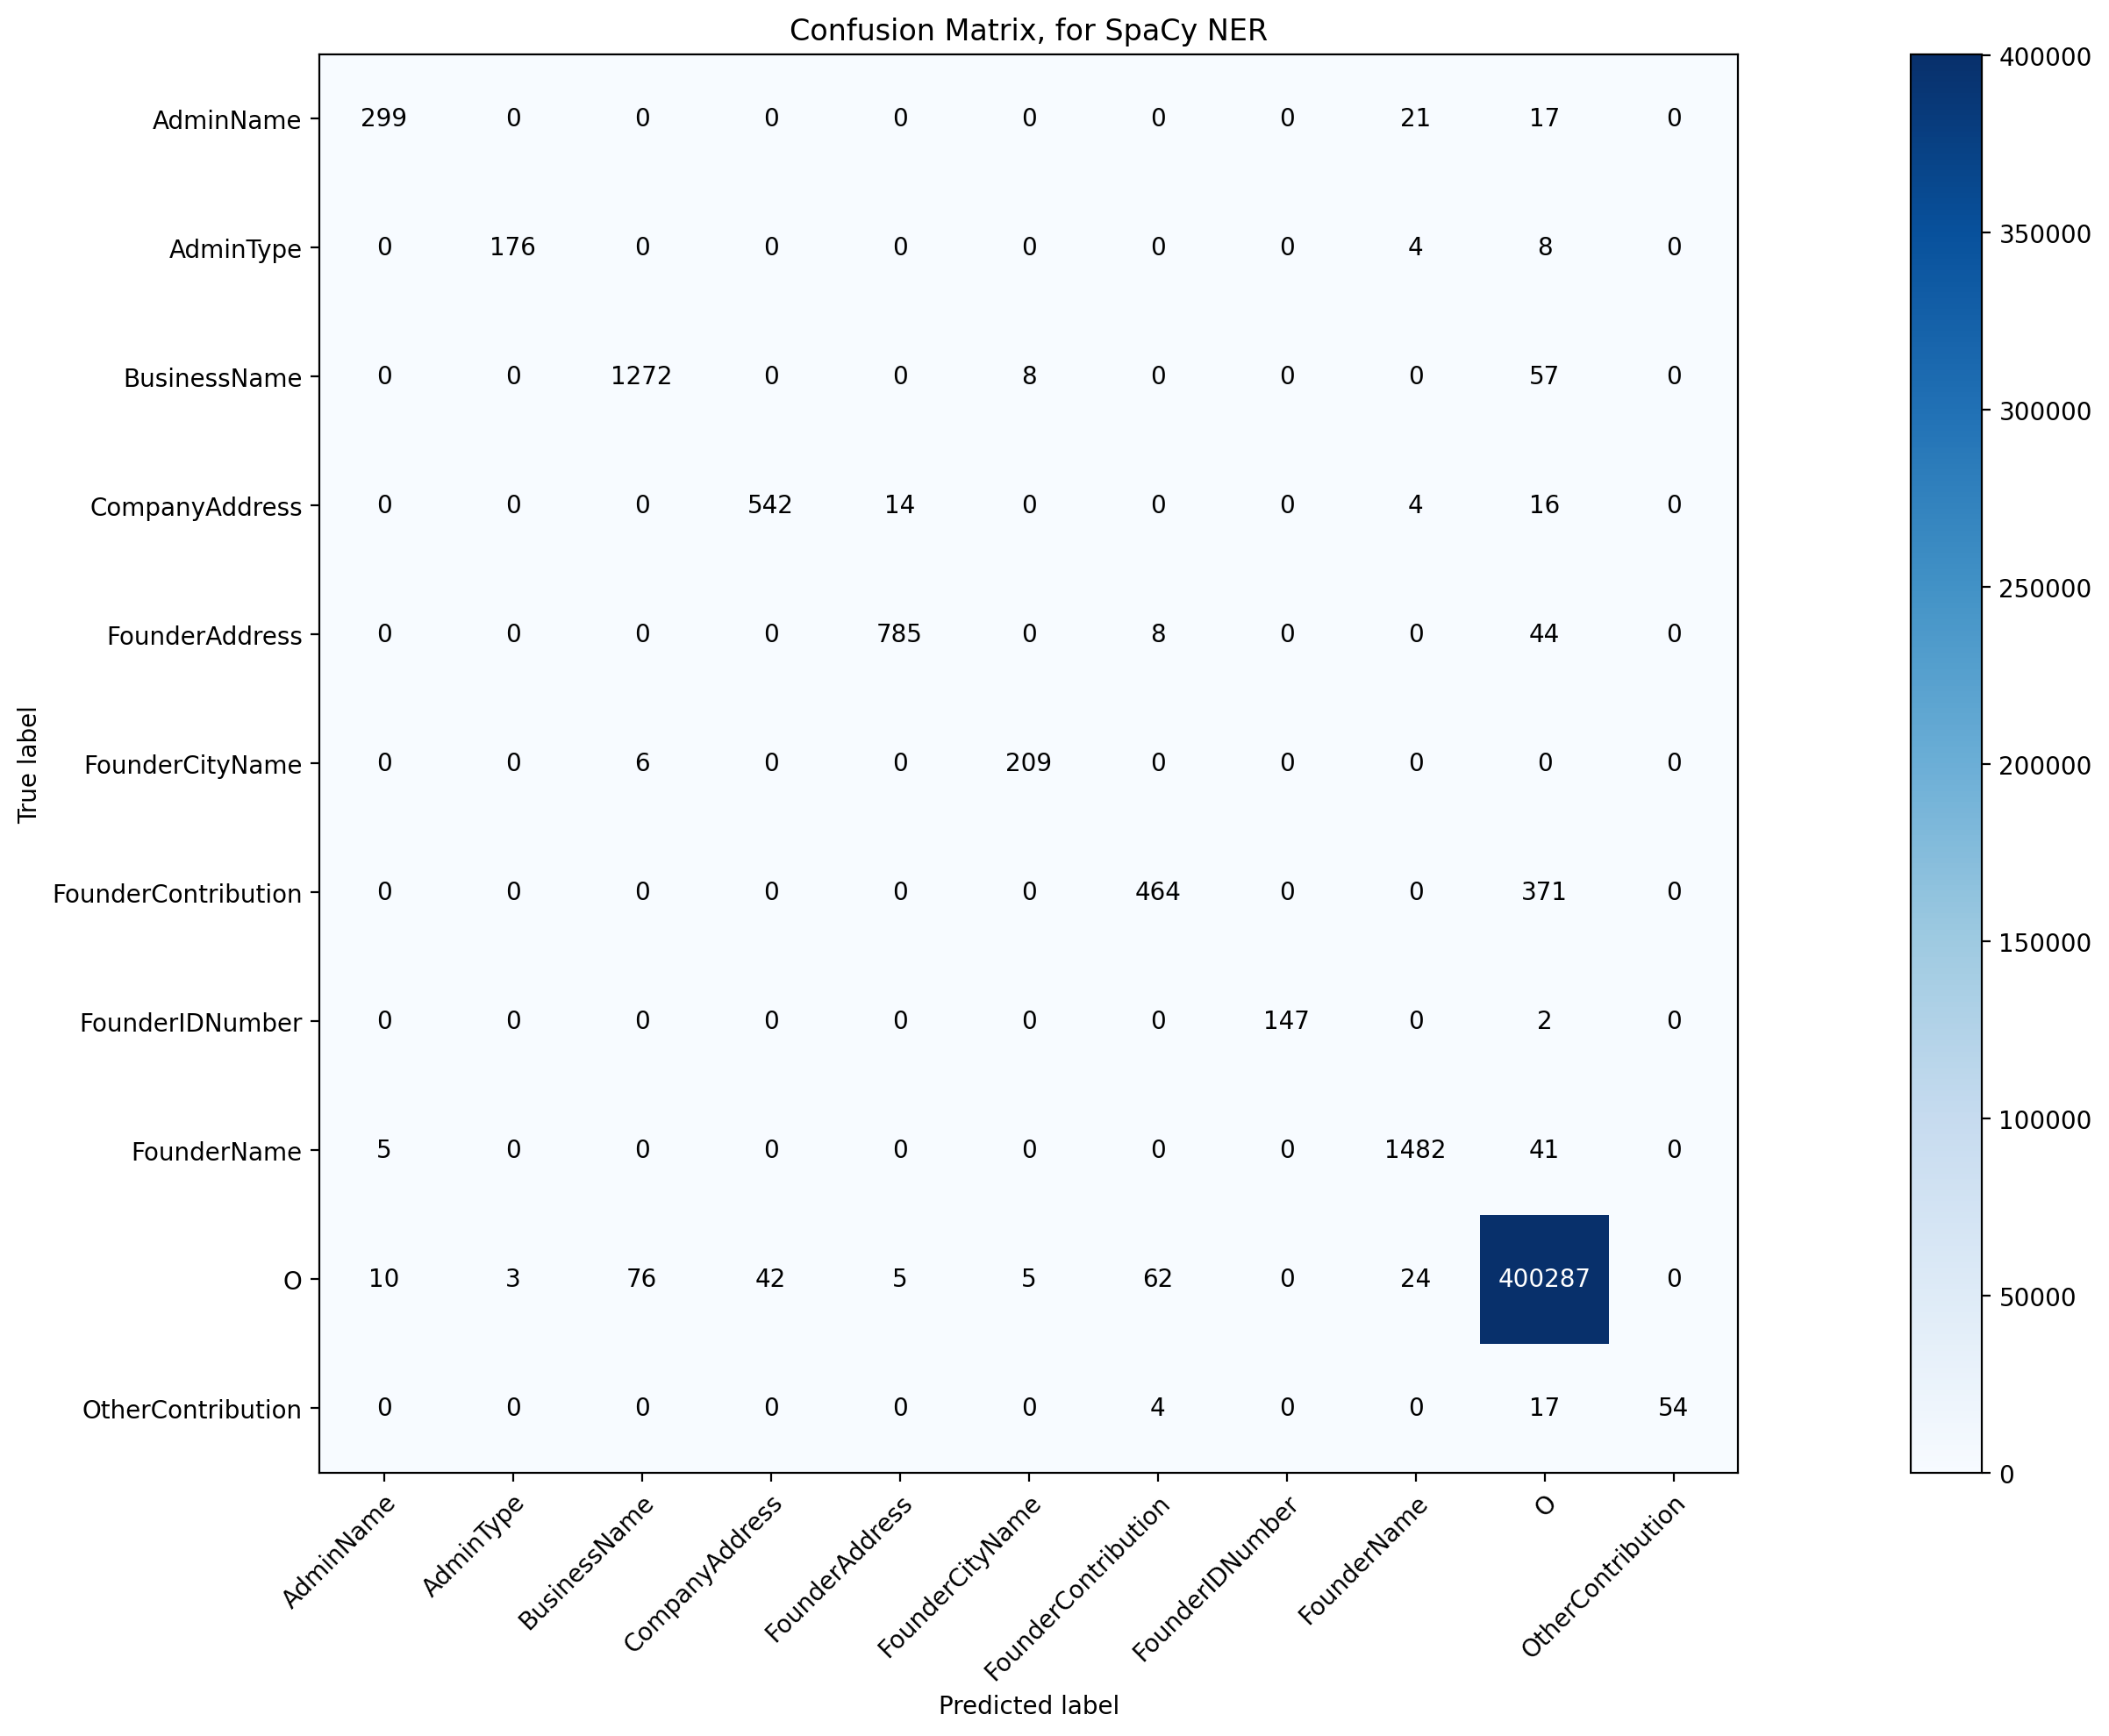

In [13]:
nlp = spacy.load('models/custom_spacy_models/400docs/')
plot_confusion_matrix(docs,classes=get_dataset_labels(),normalize=False)